# Question 1

In [18]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.sparse import isspmatrix
from scipy.stats import norm, skew
import numpy as np
%matplotlib inline

In [3]:
train_set = pd.read_csv('data/train.csv')
test_set = pd.read_csv('data/test.csv')

In [4]:
train_set.head(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


SalePrice is our target variable and therefore we remove it from the train set and put it in a separate y_train df.

In [5]:
y_train = train_set[['SalePrice']]
train_set = train_set.drop(['SalePrice'], axis=1)

With a first look at the dataset we can observe categorical data and missing values expressed in NaN. We need to fix them before proceeding with the prediction. Specifically, transform categorical data to dummy values and fill NaN values with the mean value of the dataset. Since we need to fix both train and test set it makes sence to merge into a dataframe and then separate them once more.

In [6]:
train_test_data =  pd.concat((train_set.loc[:,'MSSubClass':'SaleCondition'], test_set.loc[:, 'MSSubClass':'SaleCondition']))
train_test_data.head(5)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal


We should also plot the target variable to check for skewness and if normalization is needed.

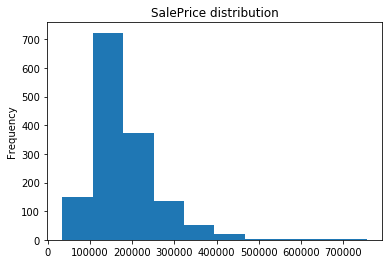

In [7]:
plt.hist(y_train['SalePrice'])
plt.ylabel('Frequency')
plt.title('SalePrice distribution')
plt.show()

We can observe that the sale price variable is positively skewed since the blue line is deviated towards the right which means there is assymetry in the distribution and therefore we need to fix it to be normally distributed. To do so the best fix is to perform a log transform in the sales price and the features that suffer from skewness as well.

In [8]:
skewness = train_test_data.skew()
# skew values over 1.00 and below -1.00 indicate substantial skewness 
skewness = skewness[(skewness>1.00)].index
skewness

Index(['MSSubClass', 'LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1',
       'BsmtFinSF2', 'TotalBsmtSF', '1stFlrSF', 'LowQualFinSF', 'GrLivArea',
       'BsmtHalfBath', 'KitchenAbvGr', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal'],
      dtype='object')

In [9]:
train_test_data['MSSubClass'] = train_test_data['MSSubClass'].astype('category')
train_test_data['OverallQual'] = train_test_data['OverallQual'].astype('category')
train_test_data['OverallCond'] = train_test_data['OverallCond'].astype('category')

In [10]:
train_test_data = pd.get_dummies(train_test_data)

In [11]:
train_test_data = train_test_data.fillna(0.0)

In [12]:
x_train = train_test_data[:train_set.shape[0]]
x_test = train_test_data[train_set.shape[0]:]

In [33]:
features_corr = x_train.corr().abs()
features_corr[features_corr==1.0]=0.0


LotFrontage                   NaN
LotArea                       NaN
YearBuilt                     NaN
YearRemodAdd                  NaN
MasVnrArea                    NaN
BsmtFinSF1                    NaN
BsmtFinSF2               0.716235
BsmtUnfSF                     NaN
TotalBsmtSF              0.819530
1stFlrSF                 0.819530
2ndFlrSF                 1.597899
LowQualFinSF                  NaN
GrLivArea                0.825489
BsmtFullBath                  NaN
BsmtHalfBath                  NaN
FullBath                      NaN
HalfBath                      NaN
BedroomAbvGr                  NaN
KitchenAbvGr                  NaN
TotRmsAbvGrd             0.825489
Fireplaces                    NaN
GarageYrBlt              1.499964
GarageCars               0.882475
GarageArea               0.882475
WoodDeckSF                    NaN
OpenPorchSF                   NaN
EnclosedPorch                 NaN
3SsnPorch                     NaN
ScreenPorch                   NaN
PoolArea      

In [20]:
print (np.count_nonzero(x_train)/np.size(x_train))

0.1948009417808219


## Models

In [35]:
import xgboost as xgb
from sklearn import linear_model
from sklearn.cross_validation import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import train_test_split
from sklearn.metrics import r2_score

In [38]:
X_tr, X_tst, y_tr, y_tst = train_test_split(x_train, y_train, test_size=0.3, random_state=0)
linreg = linear_model.LinearRegression()
linreg.fit(X_tr, y_tr)
y_pred = linreg.predict(X_tst)
print("logreg",r2_score(y_tst, y_pred))

logreg 0.6057709863269731


In [24]:
X_tr, X_tst, y_tr, y_tst = train_test_split(x_train, y_train, test_size=0.3, random_state=0)
xgb_model = xgb.XGBRegressor(n_estimators=100, learning_rate=0.08, gamma=0, subsample=0.75,
                           colsample_bytree=1, max_depth=7)
xgb_model.fit(X_tr,y_tr)
y_pred = xgb_model.predict(X_tst)
print(explained_variance_score(y_pred,y_tst))

0.8134457348239967


In [42]:
X_tr, X_tst, y_tr, y_tst = train_test_split(x_train, y_train, test_size=0.3, random_state=0)
rfc = RandomForestRegressor(random_state=0, n_estimators=100)
score = cross_val_score(rfc, X_tr, y_tr).mean()
print("Score with the entire dataset = %.2f" % score)

/home/vasia/miniconda2/envs/p3env/lib/python3.5/site-packages/sklearn/cross_validation.py:1675: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/vasia/miniconda2/envs/p3env/lib/python3.5/site-packages/sklearn/cross_validation.py:1675: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/vasia/miniconda2/envs/p3env/lib/python3.5/site-packages/sklearn/cross_validation.py:1675: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


Score with the entire dataset = 0.84


In [46]:
 param_grid = { 
            "n_estimators"      : [250, 300],
           "max_features"      : [3, 5],
           "max_depth"         : [3, 20],
           "min_samples_split" : [2, 4] ,
           "bootstrap": [True, False]}

CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5)
CV_rfc.fit(X_tr, y_tr)
print (CV_rfc.best_params_)

/home/vasia/miniconda2/envs/p3env/lib/python3.5/site-packages/sklearn/cross_validation.py:1675: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/vasia/miniconda2/envs/p3env/lib/python3.5/site-packages/sklearn/cross_validation.py:1675: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/vasia/miniconda2/envs/p3env/lib/python3.5/site-packages/sklearn/cross_validation.py:1675: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/vasia/miniconda2/envs/p3env/lib/python3.5/site-packages/sklearn/cross_validation.py:1675: DataCon

/home/vasia/miniconda2/envs/p3env/lib/python3.5/site-packages/sklearn/cross_validation.py:1675: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/vasia/miniconda2/envs/p3env/lib/python3.5/site-packages/sklearn/cross_validation.py:1675: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/vasia/miniconda2/envs/p3env/lib/python3.5/site-packages/sklearn/cross_validation.py:1675: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/vasia/miniconda2/envs/p3env/lib/python3.5/site-packages/sklearn/cross_validation.py:1675: DataCon

/home/vasia/miniconda2/envs/p3env/lib/python3.5/site-packages/sklearn/cross_validation.py:1675: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/vasia/miniconda2/envs/p3env/lib/python3.5/site-packages/sklearn/cross_validation.py:1675: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/vasia/miniconda2/envs/p3env/lib/python3.5/site-packages/sklearn/cross_validation.py:1675: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/vasia/miniconda2/envs/p3env/lib/python3.5/site-packages/sklearn/cross_validation.py:1675: DataCon

/home/vasia/miniconda2/envs/p3env/lib/python3.5/site-packages/sklearn/cross_validation.py:1675: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/vasia/miniconda2/envs/p3env/lib/python3.5/site-packages/sklearn/cross_validation.py:1675: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/vasia/miniconda2/envs/p3env/lib/python3.5/site-packages/sklearn/cross_validation.py:1675: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/vasia/miniconda2/envs/p3env/lib/python3.5/site-packages/sklearn/cross_validation.py:1675: DataCon

/home/vasia/miniconda2/envs/p3env/lib/python3.5/site-packages/sklearn/cross_validation.py:1675: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/vasia/miniconda2/envs/p3env/lib/python3.5/site-packages/sklearn/cross_validation.py:1675: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/vasia/miniconda2/envs/p3env/lib/python3.5/site-packages/sklearn/cross_validation.py:1675: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/vasia/miniconda2/envs/p3env/lib/python3.5/site-packages/sklearn/cross_validation.py:1675: DataCon

/home/vasia/miniconda2/envs/p3env/lib/python3.5/site-packages/sklearn/cross_validation.py:1675: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/vasia/miniconda2/envs/p3env/lib/python3.5/site-packages/sklearn/cross_validation.py:1675: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/vasia/miniconda2/envs/p3env/lib/python3.5/site-packages/sklearn/cross_validation.py:1675: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/vasia/miniconda2/envs/p3env/lib/python3.5/site-packages/sklearn/cross_validation.py:1675: DataCon

{'bootstrap': False, 'max_features': 5, 'max_depth': 20, 'n_estimators': 300, 'min_samples_split': 2}


In [48]:
rfc = RandomForestRegressor(random_state=0, n_estimators=300, max_depth=20, max_features=5, min_samples_split=2, bootstrap=False)
score = cross_val_score(rfc, X_tr, y_tr).mean()
print("Score with the entire dataset = %.2f" % score)

/home/vasia/miniconda2/envs/p3env/lib/python3.5/site-packages/sklearn/cross_validation.py:1675: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/vasia/miniconda2/envs/p3env/lib/python3.5/site-packages/sklearn/cross_validation.py:1675: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/vasia/miniconda2/envs/p3env/lib/python3.5/site-packages/sklearn/cross_validation.py:1675: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


Score with the entire dataset = 0.81
